# Mushrooms classification



### Import used modules

The only external modules used for this notebook are [numpy](http://www.numpy.org/), [tensorflow](https://www.tensorflow.org/), and [matplotlib](https://matplotlib.org/).

In [1]:
import tensorflow as tf

In [2]:
%matplotlib inline

import sys
from pathlib import Path

import numpy as np
#import tensorflow as tf
import matplotlib.pyplot as plt

## Load the processed data

First we need to load the processed data. This files are loaded as numpy arrays.

In [3]:
training_data = np.load(open("training_data/mushrooms_training_data.npy", 'rb'))
training_labels = np.load(open("training_data/mushrooms_training_labels.npy", 'rb'))
validation_data = np.load(open("training_data/mushrooms_validation_data.npy", 'rb'))
validation_labels = np.load(open("training_data/mushrooms_validation_labels.npy", 'rb'))
test_data = np.load(open("training_data/mushrooms_test_data.npy", 'rb'))
test_labels = np.load(open("training_data/mushrooms_test_labels.npy", 'rb'))

Print data type and arrays shapes.

In [4]:
print("Loaded data type = {}".format(type(training_data)))
print("Training data shape = {}".format(training_data.shape))
print("Training labels shape = {}".format(training_labels.shape))
print("Validation data shape = {}".format(validation_data.shape))
print("Validation labels shape = {}".format(validation_labels.shape))
print("Test data shape = {}".format(test_data.shape))
print("Test labels shape = {}".format(test_labels.shape))

Loaded data type = <class 'numpy.ndarray'>
Training data shape = (6500, 117)
Training labels shape = (6500, 1)
Validation data shape = (812, 117)
Validation labels shape = (812, 1)
Test data shape = (812, 117)
Test labels shape = (812, 1)


## Create model

Now we will define our neural network model. We will create a [Keras](https://www.tensorflow.org/guide/keras) model that we can later train. We need to perform the next operations
- **Inputs**: We need to create keras inputs for the model. We will need only a data input.
- **Hidden layers**: In this model we will use a stack of keras [fully connected layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). The number, size and activation function of this layers can be changed from the model parameters variables.
- **Output layer**: We will use a fully connected layer, with size 1 (one neuron) and a [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function (the standart output function for binary classification).
- **Instantiate model**: We create de keras model indicating the input and output of it.
- **Compile model**: We compile the model with the loss function we want to use, the optimizer and the metrics we want to keep trak of.
- **Callbacks**: Utilities called at certain points during model training ([info](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)).

### Model parameters

This parameters are used to easily change the model architecture to try different configurations and find the best for our specific task.

In [5]:
# Parameters
fully_connected_layers = 3
fully_connected_size = 50
fully_connected_activation = "relu"

### Training hyperparameters

These are the hyperparameters we need to tune in order to get the model and training to work. Try different values to see how the training and model performance change.

In [6]:
# Hyperparameters
epochs = 50
batch_size = 128
learning_rate = 0.01

### Create model inputs

We first create the model inputs. This are later used to feed data to the model. We need only a data input for this model.

In [7]:
#tf.reset_default_graph()
tf.compat.v1.reset_default_graph()

# The shape (None, 117) refers to a tensor or multidimensional array with two dimensions. The first dimension has a size of "None" which means it can take any non-negative integer value, and the second dimension has a fixed size of 117.

In machine learning, the "None" dimension is typically used to represent the batch size of the data. The batch size refers to the number of samples that are processed simultaneously during training or inference. The use of a variable batch size allows for efficient use of hardware resources, as well as greater flexibility in training and inference.

Therefore, if you see a tensor or multidimensional array with shape (None, 117) in a machine learning context, it means that the input data has a fixed number of features (117), but the number of samples can vary depending on the batch size used during training or inference.

In [8]:
# Data input
x = tf.keras.Input(shape=(training_data.shape[1], ), name="inputs")
print(x)

KerasTensor(type_spec=TensorSpec(shape=(None, 117), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")


In [9]:
dense_layers = fully_connected_layers

# Create first dense layer
# Shape: (batch_size, fully_connected_size)
dense = tf.keras.layers.Dense(fully_connected_size,
                              activation=fully_connected_activation,
                              name="dense_1")(x)

print(dense)

dense_layers -= 1
dense_layer_count = 2

# Create next dense layers
for i in range(dense_layers):
    # Shape: (batch_size, fully_connected_size)
    dense = tf.keras.layers.Dense(fully_connected_size,
                                  activation=fully_connected_activation,
                                  name="dense_{}".format(dense_layer_count))(dense)
    
    print(dense)
    
    dense_layer_count += 1

KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name=None), name='dense_1/Relu:0', description="created by layer 'dense_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name=None), name='dense_2/Relu:0', description="created by layer 'dense_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name=None), name='dense_3/Relu:0', description="created by layer 'dense_3'")


### Create output layer

In [10]:
# Shape: (batch_size, 1)
output_layer = tf.keras.layers.Dense(1,
                                     activation="sigmoid",
                                     name="output_layer")(dense)

print(output_layer)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='output_layer/Sigmoid:0', description="created by layer 'output_layer'")


### Instantiate the model

In [11]:
model = tf.keras.Model(inputs=x, outputs=output_layer)

### Compile the model

In [12]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 117)]             0         
                                                                 
 dense_1 (Dense)             (None, 50)                5900      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 output_layer (Dense)        (None, 1)                 51        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


## Model training

In [13]:
history = model.fit(training_data, training_labels,
                    epochs=epochs,
                    validation_data=(validation_data, validation_labels),
                    verbose=2,
                    batch_size=batch_size,
                    shuffle=True)

Epoch 1/50
51/51 - 0s - loss: 0.6670 - accuracy: 0.5758 - val_loss: 0.7556 - val_accuracy: 0.2328 - 418ms/epoch - 8ms/step
Epoch 2/50
51/51 - 0s - loss: 0.6050 - accuracy: 0.6500 - val_loss: 0.7198 - val_accuracy: 0.3571 - 61ms/epoch - 1ms/step
Epoch 3/50
51/51 - 0s - loss: 0.5264 - accuracy: 0.7898 - val_loss: 0.6254 - val_accuracy: 0.6958 - 59ms/epoch - 1ms/step
Epoch 4/50
51/51 - 0s - loss: 0.4236 - accuracy: 0.8697 - val_loss: 0.4771 - val_accuracy: 0.8966 - 51ms/epoch - 1ms/step
Epoch 5/50
51/51 - 0s - loss: 0.3196 - accuracy: 0.9118 - val_loss: 0.3435 - val_accuracy: 0.9286 - 69ms/epoch - 1ms/step
Epoch 6/50
51/51 - 0s - loss: 0.2371 - accuracy: 0.9415 - val_loss: 0.2561 - val_accuracy: 0.9286 - 61ms/epoch - 1ms/step
Epoch 7/50
51/51 - 0s - loss: 0.1797 - accuracy: 0.9605 - val_loss: 0.2066 - val_accuracy: 0.9298 - 48ms/epoch - 951us/step
Epoch 8/50
51/51 - 0s - loss: 0.1413 - accuracy: 0.9686 - val_loss: 0.1780 - val_accuracy: 0.9323 - 72ms/epoch - 1ms/step
Epoch 9/50
51/51 - 0s

## Plot cost and accuracy during training

Now we plot the how the cost and accuracy change during training, for both the training data and the validation data.

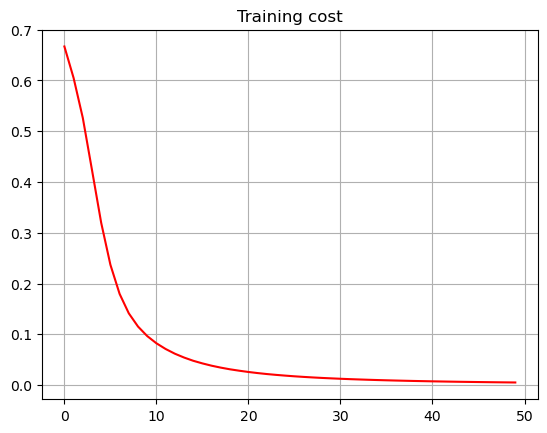

In [14]:
plt.plot(range(len(history.history["loss"])), history.history["loss"], color="red")
plt.title("Training cost")
plt.grid()

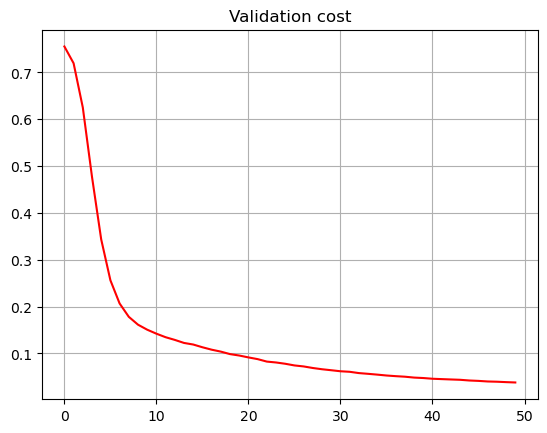

In [16]:
plt.plot(range(len(history.history["val_loss"])), history.history["val_loss"], color="red")
plt.title("Validation cost")
plt.grid()

## Test model

We will use the test data we have loaded to test our model performance on unseen data.

In [18]:
test_results = model.evaluate(test_data,
                              test_labels,
                              batch_size=None,
                              verbose=1)

print("Test accuracy = {}".format(test_results[1]))

26/26 [==============================] - 0s 1ms/step - loss: 0.0926 - accuracy: 0.9914
Test accuracy = 0.9913793206214905
